In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import joblib
from jax import jit

from qdots_qll.process_representations import *

from qdots_qll.all_funcs import create_dij

from functools import partial
import scipy
import matplotlib.pyplot as plt

In [2]:
import h5py

def import_hdf5(filename):
    f = h5py.File(filename, "r")
    a_group_key = list(f.keys())[0]
    data = list(f[a_group_key])
    return np.array(data)


arr = import_hdf5("numerical_L_true_mathematica.hdf5")

L_true_math = arr["Re"] + 1j * arr["Im"]

In [3]:
def plot_compare_L(L1, L2, E_i):
    plt.plot(
        times,
        np.real(
            np.trace(
                np.einsum(
                    "kl, ilm",
                    E_i,
                    (
                        scipy.linalg.expm(np.einsum("i, jk -> ijk", times, L1))
                        @ rho
                    ).reshape([-1, 2, 2]),
                ),
                axis1=1,
                axis2=2,
            )
        ),
        label="A",
    )

    plt.plot(
        times,
        np.real(
            np.trace(
                np.einsum(
                    "kl, ilm",
                    E_i,
                    (
                        scipy.linalg.expm(np.einsum("i, jk -> ijk", times, L2))
                        @ rho
                    ).reshape([-1, 2, 2]),
                ),
                axis1=1,
                axis2=2,
            )
        ),
        label="B",
    )
    plt.legend()
    plt.show()

In [4]:
@partial(jit, static_argnums=1)
def create_dij(particle, h_dim):
    d = h_dim
    dij = jnp.zeros([d**2 - 1, d**2 - 1], dtype=jnp.complex64)

    dij = dij.at[0, 2].set(particle[0] + 1j * particle[1])
    dij = dij.at[1, 2].set(particle[2] + 1j * particle[3])

    dij = dij + jnp.conjugate(dij.T)
    dij = dij.at[2, 2].set(particle[4])
    return dij


@partial(jit, static_argnums=1)
def make_liouvillian(H, h_dim):
    d = h_dim
    return 1j * jnp.kron(H.T, jnp.identity(d)) - 1j * jnp.kron(
        jnp.identity(d), H
    )


@jit
def make_H_renormalization(particles_h):
    return jnp.array(
        [
            [particles_h[0], particles_h[1] + 1j * particles_h[2]],
            [particles_h[1] - 1j * particles_h[2], 0],
        ]
    )

In [33]:
mat_gg = np.zeros([N**2, N**2, N**2, N**2], dtype=np.complex64)
for i, gi in enumerate(list(G)):
    for j, gj in enumerate(list(G)):
        # print(i, j)
        val = np.kron(np.transpose(gj), gi)
        val = val - 0.5*np.kron(np.identity(2), gj@gi)
        val = val - 0.5*np.kron(np.transpose(gj@gi), np.identity(2))
        mat_gg[i, j] =  val


@jit
def dij_gg(dij, mat_gg):
    return jnp.einsum("ij, ijkl -> kl", dij, mat_gg[1:, 1:])

In [34]:
re = jnp.real(to_chi_from_super(L_true_math)[1:, -1])
im = jnp.imag(to_chi_from_super(L_true_math)[1:, -1])

In [7]:
true_vals_dissipator = jnp.array(
    [val for pair in zip(list(re), list(im)) for val in pair][:-1]
)

true_vals_reH = jnp.array([-0.127393, -0.489548, 0.000723])

In [76]:
true_vals = np.array(list(true_vals_reH) + list( true_vals_dissipator))
joblib.dump(true_vals, "true_vals.job")

['true_vals.job']

In [11]:
delta = 0.12739334807998307
Omega = 0.5

A = np.array([[1, 0], [0, 0]])
sigmap = np.array([[0, 1], [0, 0]])
sigman = np.array([[0, 0], [1, 0]])


H0 = delta * A + Omega / 2 * (sigmap + sigman)


In [86]:
times = np.linspace(0, 600, 1000)



rho = np.array([1, 0, 0, 0])
E_i = np.array([[1, 0], [0, 0]])

np.trace(
    E_i
    @ (
        scipy.linalg.expm(np.einsum("i, jk -> ijk", times, L_true_math)) @ rho
    ).reshape([-1, 2, 2])
)

array([1.+0.j, 0.+0.j])

In [77]:
def plot_compare_L(L1, L2, E_i):
    plt.plot(
        times,
        np.real(
            np.trace(
                np.einsum(
                    "kl, ilm",
                    E_i,
                    (
                        scipy.linalg.expm(np.einsum("i, jk -> ijk", times, L1))
                        @ rho
                    ).reshape([-1, 2, 2]),
                ),
                axis1=1,
                axis2=2,
            )
        ),
        label="A",
    )

    plt.plot(
        times,
        np.real(
            np.trace(
                np.einsum(
                    "kl, ilm",
                    E_i,
                    (
                        scipy.linalg.expm(np.einsum("i, jk -> ijk", times, L2))
                        @ rho
                    ).reshape([-1, 2, 2]),
                ),
                axis1=1,
                axis2=2,
            )
        ),
        label="B",
    )
    plt.legend()
    plt.show()

In [80]:
true_vals.shape

(8,)

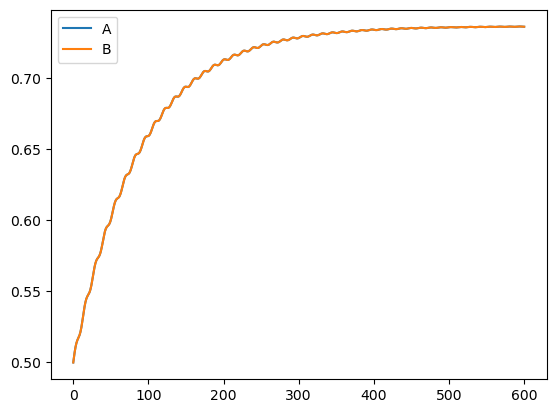

In [89]:
E_i = np.array([[1, -1], [-1, 1]])/2

L_reconstructed = make_liouvillian(
    H0 +
    make_H_renormalization(true_vals[0:3]), 2
) + dij_gg(create_dij(true_vals[3:], 2), mat_gg)


plot_compare_L(
    L_true_math,
    L_reconstructed,
    E_i,
)

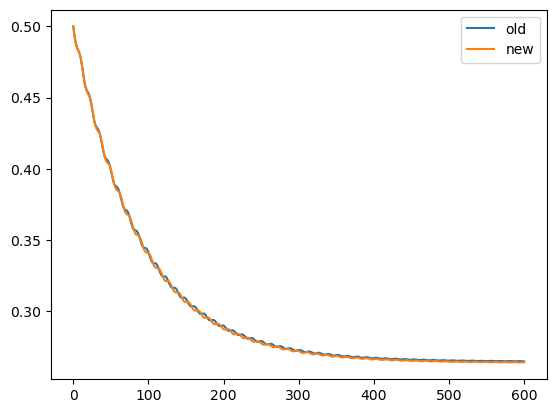

In [192]:
E_i = np.array([[1, 1], [1, 1]]) / 2

plt.plot(
    times,
    np.real(
        np.trace(
            np.einsum(
                "kl, ilm",
                E_i,
                (
                    scipy.linalg.expm(
                        np.einsum("i, jk -> ijk", times, L_true.full())
                    )
                    @ rho
                ).reshape([-1, 2, 2]),
            ),
            axis1=1,
            axis2=2,
        )
    ),
    label="old",
)

plt.plot(
    times,
    np.real(
        np.trace(
            np.einsum(
                "kl, ilm",
                E_i,
                (
                    scipy.linalg.expm(
                        np.einsum("i, jk -> ijk", times, L_true_math)
                    )
                    @ rho
                ).reshape([-1, 2, 2]),
            ),
            axis1=1,
            axis2=2,
        )
    ),
    label="new",
)

plt.legend()
plt.show()